Only endpoint: doesn't work so well. Initialize with controls from trajectory tracking: won't improve. 
Probably need to look at learning rate (regularization). Need to increase regularization when cost didn't decrease. 
Need to batch within run_ilqr function, then determine learning rate based on mean decrease?

In [1]:
import jax
from jax import numpy as np
from jax.lax import scan
from jax import vmap, jit
import numpy as onp
from scipy.interpolate import interp1d

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("RdYlBu", 8)

import sys
sys.path.append("../src/")
import arm_model
import ilqr_arm

/home/mkp127/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Load data

dict_keys(['torques', 'positions', 'states'])


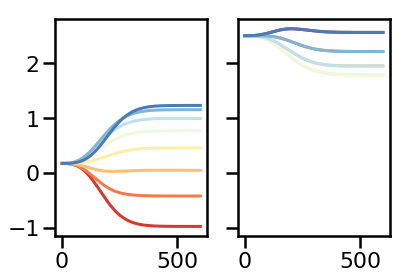

In [2]:
with open('../data/arm_dt10.pickle', 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())
# Initial state of the arm [x1, x2, x1_dot, x2_dot]
x0 = d['states'][:,0] 
# Target output: 
target_trj = interp1d(np.arange(60), d['states'], axis=1, fill_value='extrapolate')(np.arange(0, 60, 0.1))
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
for i in range(8):
    ax[0].plot(target_trj[i,:,0])
    ax[1].plot(target_trj[i,:,1])

## Trajectory tracking

In [3]:
regu = 1e-5
lmbda = 1e-5
kappa = 1e-0

In [28]:
prep = d['states'][:,0,:2][:,None].repeat(300, 1)
move = interp1d(np.arange(30), d['states'][:,::2,:2], axis=1, fill_value='extrapolate')(np.arange(0, 30, 0.1))
target_trj = np.concatenate((prep, move),1)

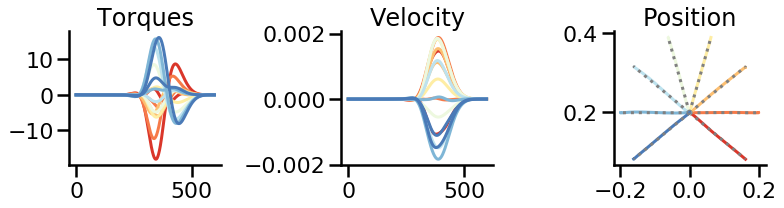

In [37]:
x_trj, u_trj, cost_trace = ilqr_arm.run_ilqr_batch(x0, target_trj[:,:,:2], None, 10, regu, lmbda, kappa)
y_trj = arm_model.get_position_batch(x_trj)
y_target = arm_model.get_position_batch(d['states'])

f, ax = plt.subplots(1,3, figsize=(11,3))
for i in range(8):
    ax[0].plot(u_trj[i], c=sns.color_palette()[i])
    ax[1].plot(np.diff(y_trj[i], axis=0), c=sns.color_palette()[i])
    ax[2].plot(y_trj[i,:,0], y_trj[i,:,1])
    ax[2].plot(y_target[i, :,0], y_target[i, :,1],":", color='gray')
    
ax[0].set_title("Torques")
ax[1].set_title("Velocity")
ax[2].set_title("Position")
sns.despine()
f.tight_layout()

## Endpoint

In [53]:
from importlib import reload
reload(ilqr_arm)

<module 'ilqr_arm' from '../src/ilqr_arm.py'>

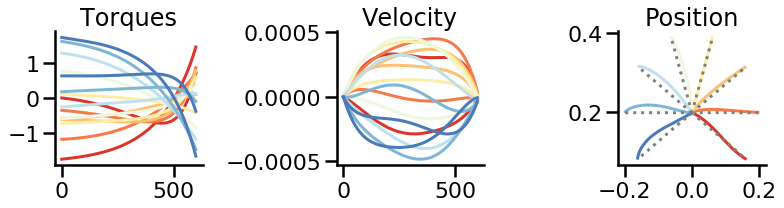

In [66]:
x_trj_new, u_trj_new, cost_trace = ilqr_arm.run_ilqr_batch(x0, target_trj[:,::,:2], None, 200, 0.001, 1e-5, 0.0)
y_trj_new = arm_model.get_position_batch(x_trj_new)
y_target = arm_model.get_position_batch(d['states'])

f, ax = plt.subplots(1,3, figsize=(11,3))
for i in range(8):
    ax[0].plot(u_trj_new[i], c=sns.color_palette()[i])
    ax[1].plot(np.diff(y_trj_new[i], axis=0), c=sns.color_palette()[i])
    ax[2].plot(y_trj_new[i,:,0], y_trj_new[i,:,1])
    ax[2].plot(y_target[i, :,0], y_target[i, :,1],":", color='gray')
    
ax[0].set_title("Torques")
ax[1].set_title("Velocity")
ax[2].set_title("Position")
sns.despine()
f.tight_layout()

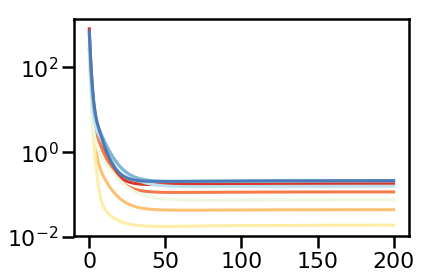

In [67]:
plt.semilogy(cost_trace.T)

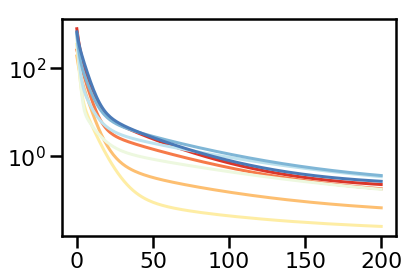

In [65]:
plt.semilogy(cost_trace.T)